Predicted states (in-sample):
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    1
51    1
52    1
53    1
54    1
55    1
56    1
57    1
58    1
59    1
60    1
61    1
62    1
63    1
64    1
65    1
66    1
67    1
68    1
69    1
70    1
71    1
72    1
73    1
74    1
75    1
76    1
77    1
78    1
79    1
80    1
81    1
82    1
83    1
84    1
85    1
86    1
87    1
88    1
89    1
90    1
91    1
92    1
93    1
94    1
95    1
96    1
97    1
98    1
99    1
dtype: int64
SJM Feature Weights:
returns         0.094762
volatility      0.792921
yield_spread    0.702277
returns2        0.000000
volatility2     0.775341
dtype: floa

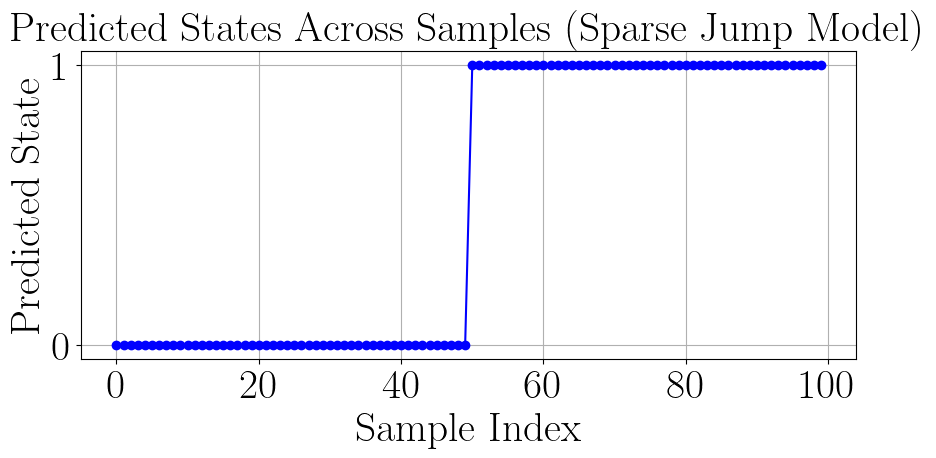

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import jumpmodels.plot
import jumpmodels.utils
from jumpmodels.sparse_jump import SparseJumpModel  # use the sparse model
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd

np.random.seed(42)
n_samples = 100

# Create a state indicator for simulation: first 50 samples in state 0, next 50 in state 1
states_true = np.array([0]*50 + [1]*50)

# Simulate original returns:
returns = np.concatenate([
    np.random.normal(0.01, 0.01, 50),  # State 0: positive mean, low std
    np.random.normal(-0.01, 0.02, 50)   # State 1: negative mean, higher std
])

# Simulate original volatility (e.g., realized volatility):
volatility = np.concatenate([
    np.random.normal(0.05, 0.005, 50),  # State 0: lower volatility
    np.random.normal(0.1, 0.01, 50)      # State 1: higher volatility
])

# Simulate yield spread:
yield_spread = np.concatenate([
    np.random.normal(0.02, 0.005, 50),  # State 0: higher yield spread
    np.random.normal(0.005, 0.002, 50)  # State 1: lower yield spread
])

# Simulate additional returns (returns2):
returns2 = np.concatenate([
    np.random.normal(0.005, 0.008, 50),  # State 0: positive mean, low std
    np.random.normal(-0.005, 0.015, 50)  # State 1: negative mean, higher std
])

# Simulate additional volatility (volatility2):
volatility2 = np.concatenate([
    np.random.normal(0.04, 0.004, 50),  # State 0: lower volatility
    np.random.normal(0.08, 0.008, 50)   # State 1: higher volatility
])

# Combine features into a DataFrame (each column is a feature)
df = pd.DataFrame({
    "returns": returns,
    "volatility": volatility,
    "yield_spread": yield_spread,
    "returns2": returns2,
    "volatility2": volatility2
})

# Use the second return series as the returns series for financial anchoring
ret_ser = df["returns"]

# -------------------------
# Preprocessing
# -------------------------
# Clip the data within 3 standard deviations to mitigate the impact of outliers
clipper = DataClipperStd(mul=3.)
df_clipped = clipper.fit_transform(df)

# Standardize the clipped data (zero mean and unit variance)
scaler = StandardScalerPD()
df_processed = scaler.fit_transform(df_clipped)

# -------------------------
# Fit the Sparse Jump Model
# -------------------------
max_feats = 3.        # Effective number of features, corresponding to kappa^2
jump_penalty = .01    # Jump penalty (similar in magnitude to the non-sparse model)

# Initialize the SparseJumpModel with 2 components (states)
model = SparseJumpModel(n_components=2, max_feats=max_feats, jump_penalty=jump_penalty, cont=False)

# Fit the model on the preprocessed data, using ret_ser for financial anchoring (sorting by cumulative return)
model.fit(df_processed, ret_ser, sort_by="cumret")

# Predict the states on the in-sample data
predicted_states = model.predict(df_processed)
print("Predicted states (in-sample):")
print(predicted_states)

# Print the feature weights (sparse weights)
print("SJM Feature Weights:")
print(model.feat_weights)

# -------------------------
# Plot the Predicted States
# -------------------------
plt.figure(figsize=(10, 4))
plt.plot(np.arange(n_samples), predicted_states, marker='o', linestyle='-', color='blue')
plt.xlabel("Sample Index")
plt.ylabel("Predicted State")
plt.title("Predicted States Across Samples (Sparse Jump Model)")
plt.yticks([0, 1])
plt.grid(True)
plt.show()

In [ ]:
from jumpmodels.plot import plot_regimes_and_cumret, savefig_plt

ax, ax2 = plot_regimes_and_cumret(model.labels_, data.ret_ser, n_c=2, start_date=train_start, end_date=train_end, )
ax.set(title=f"In-Sample Fitted Regimes by the JM ($\\lambda$={jump_penalty})")
savefig_plt(f"{get_curr_dir()}/plots/JM_lambd-{jump_penalty}_train.pdf")

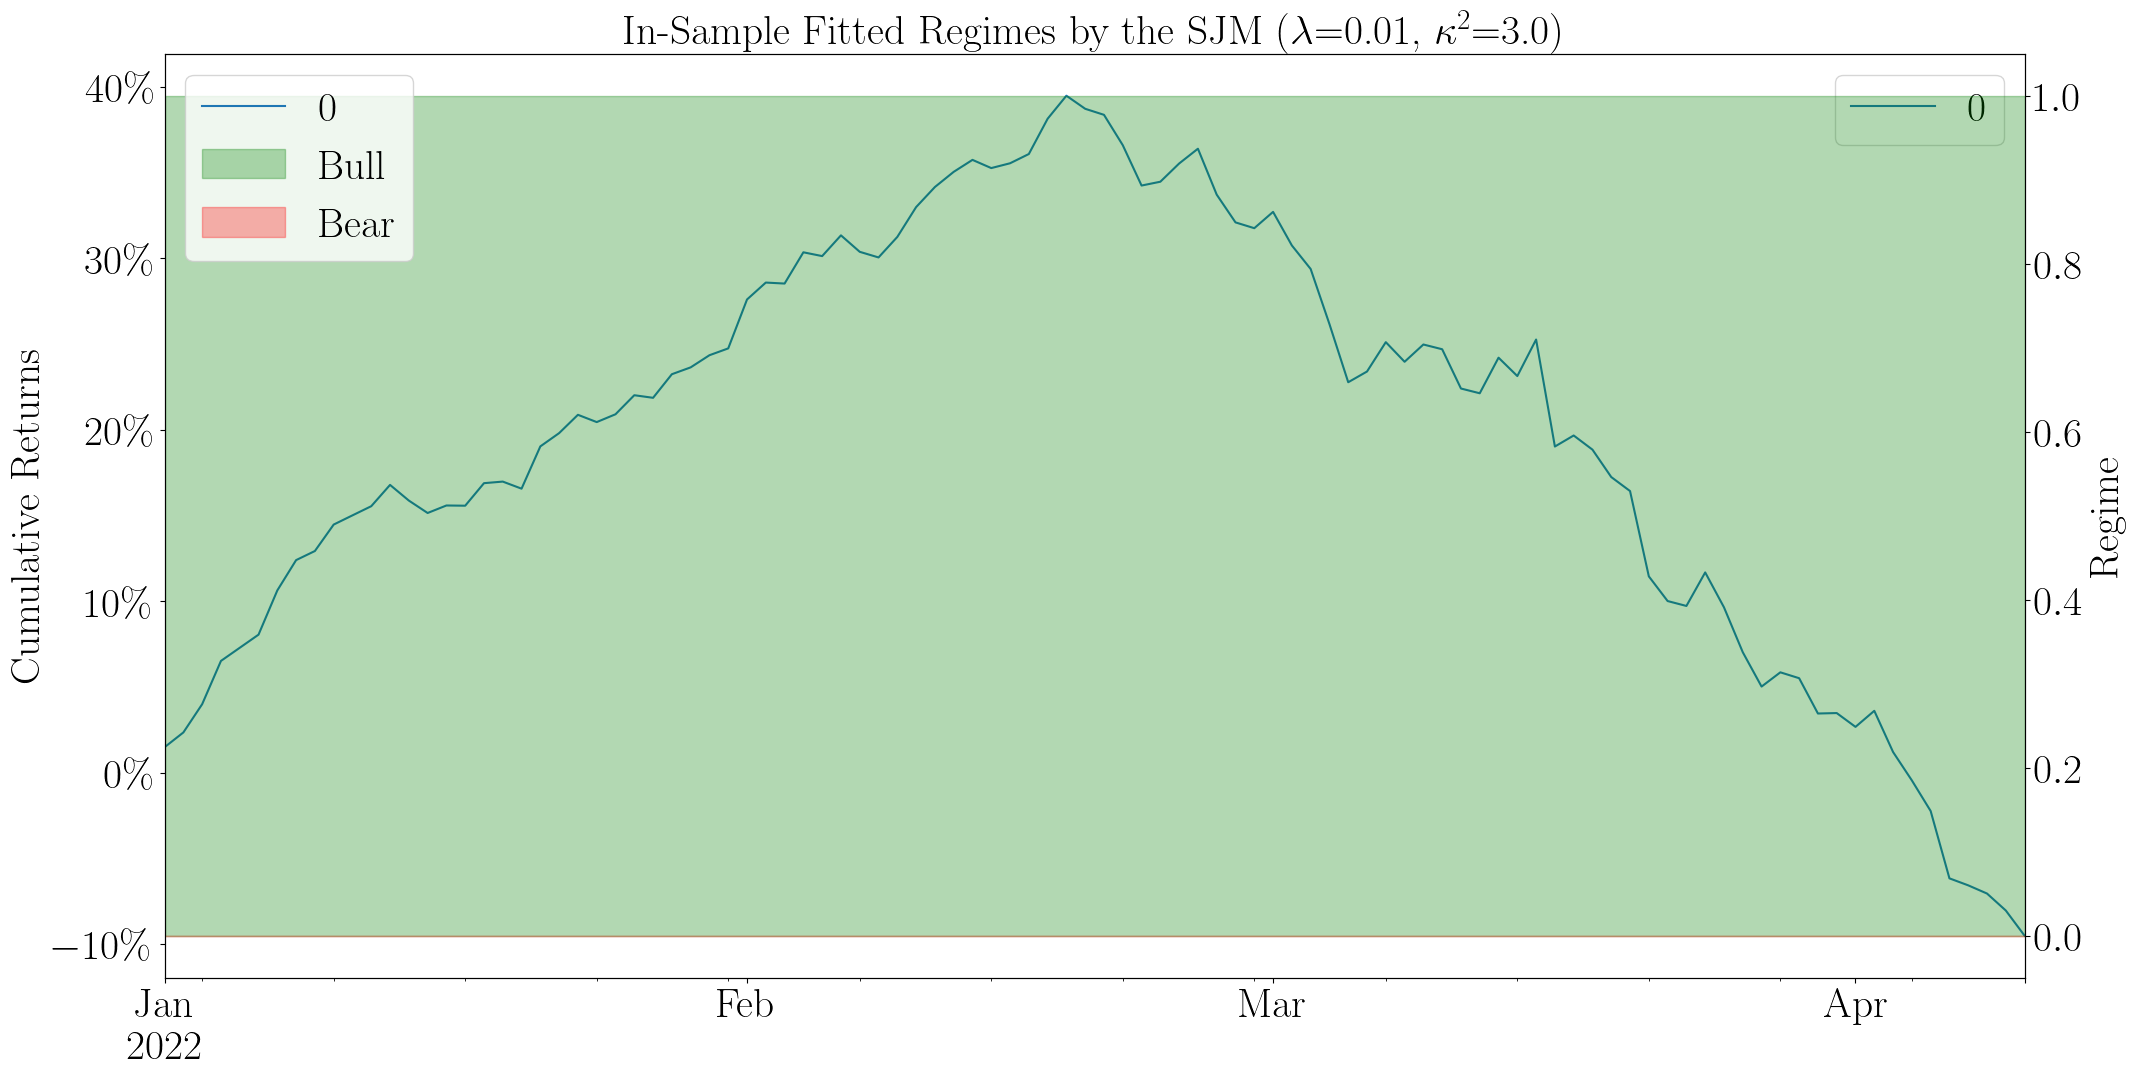

In [62]:
from jumpmodels.plot import plot_regimes_and_cumret, savefig_plt
from jumpmodels.utils import get_curr_dir
import matplotlib.pyplot as plt
import pandas as pd

# Create a date index for in‐sample (training) data
train_dates = pd.date_range(start="2022-01-01", periods=n_samples, freq='D')

# Ensure that the processed data has a proper DateTimeIndex
df_processed = pd.DataFrame(df_processed, index=train_dates, columns=df.columns)

# Re-create the return series with the same date index
ret_ser = pd.Series(ret_ser.values if hasattr(ret_ser, 'values') else ret_ser, index=train_dates)

# Convert predicted_states (from model.predict) into a Series with the same index and fill any NaNs
predicted_states = pd.Series(predicted_states, index=train_dates).fillna(0).astype(int)

# Define start and end dates as Timestamps for plotting
train_start = pd.Timestamp("2022-01-01")
train_end = train_dates[-1]

# Plot regimes and cumulative returns using the in-sample regime labels
ax, ax2 = plot_regimes_and_cumret(predicted_states, ret_ser, n_c=2, start_date=train_start, end_date=train_end)
ax.set(title=f"In-Sample Fitted Regimes by the SJM ($\\lambda$={jump_penalty}, $\\kappa^2$={max_feats})")
savefig_plt(f"{get_curr_dir()}/plots/SJM_lambd-{jump_penalty}_train.pdf")
plt.show()


In [25]:
# Inspect Clustering Results (centroids - represents the average values of your features (returns, volatility, yield spread) for that regime)
print("Cluster Centers:")
print(model.centers_)
print("Transition Matrix:")
print(model.jm_ins.transmat_)

# Understand sorting
model.fit(df, ret_ser, sort_by="vol")
print("Sorted Labels (by vol):", model.labels_)

Cluster Centers:
[[ 0.05091517 -0.76316503  0.62297178  0.         -0.73472939]
 [-0.05091517  0.76316503 -0.62297178  0.          0.73472939]]
Transition Matrix:
[[0.98 0.02]
 [0.   1.  ]]
Sorted Labels (by vol): 0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Length: 100, dtype: int64


In [27]:
# Explore summary metrics:
print("Average Returns per Regime (ret_):")
print(model.ret_)

print("\nVolatility per Regime (vol_):")
print(model.vol_)

print("\nFinal Optimized Value of Loss Function (val_):")
print(model.jm_ins.val_)

Average Returns per Regime (ret_):
[ 0.00774526 -0.00964438]

Volatility per Regime (vol_):
[0.00933669 0.0174865 ]

Final Optimized Value of Loss Function (val_):
0.008949657898305898


In [29]:
print(vars(model))


{'n_components': 2, 'max_feats': 3.0, 'jump_penalty': 0.01, 'cont': False, 'grid_size': 0.05, 'mode_loss': True, 'random_state': 0, 'max_iter': 30, 'tol_w': 0.0001, 'max_iter_jm': 1000, 'tol_jm': 1e-08, 'n_init_jm': 10, 'verbose': 0, 'n_features_all': 5, 'jm_ins': JumpModel(jump_penalty=0.004472135954999579), 'w': returns         0.098516
volatility      0.848528
yield_spread    0.081299
returns2        0.018496
volatility2     0.513169
dtype: float64, 'feat_weights': returns         0.313872
volatility      0.921156
yield_spread    0.285129
returns2        0.136001
volatility2     0.716358
dtype: float64, 'centers_': array([[ 0.00243102,  0.04587685,  0.00591781,  0.00071502,  0.02851466],
       [-0.0030271 ,  0.09288843,  0.00141357, -0.00030975,  0.0569461 ]]), 'labels_': 0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Length: 100, dtype: int64, 'proba_':       0    1
0   1.0  0.0
1   1.0  0.0
2   1.0  0.0
3   1.0  0.0
4   1.0  0.0
..  ...  .

Online Predicted States (Test):
0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Length: 100, dtype: int64


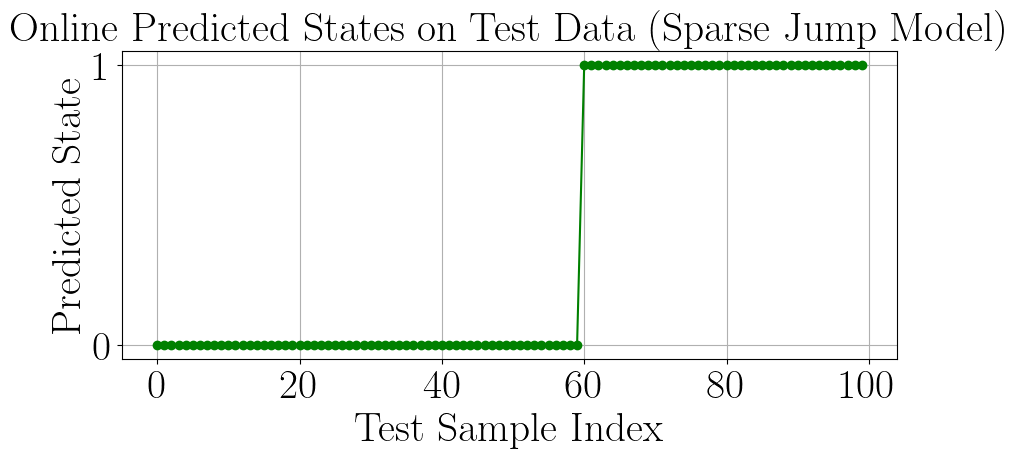

In [36]:
# -------------------------
# Simulate Test Data for Online Inference
# -------------------------
n_samples_test = 100

# Here, we use the same data generating process as training.
# Alternatively, you could introduce extra noise or shift parameters to simulate real-world changes.
returns_test = np.concatenate([
    np.random.normal(0.01, 0.01, 60),  
    np.random.normal(-0.01, 0.02, 40)  
])
volatility_test = np.concatenate([
    np.random.normal(0.05, 0.005, 60),  
    np.random.normal(0.1, 0.01, 40)     
])
yield_spread_test = np.concatenate([
    np.random.normal(0.02, 0.005, 60),  
    np.random.normal(0.005, 0.002, 40)  
])
returns2_test = np.concatenate([
    np.random.normal(0.005, 0.008, 60),  
    np.random.normal(-0.005, 0.015, 40)  
])
volatility2_test = np.concatenate([
    np.random.normal(0.04, 0.004, 60),  
    np.random.normal(0.08, 0.008, 40)   
])

df_test = pd.DataFrame({
    "returns": returns_test,
    "volatility": volatility_test,
    "yield_spread": yield_spread_test,
    "returns2": returns2_test,
    "volatility2": volatility2_test
})

# Use the same returns series for financial anchoring on test data
ret_ser_test = df_test["returns2"]

# -------------------------
# Preprocessing Test Data
# -------------------------
# Use the fitted clipper and scaler from training for consistency
df_test_clipped = clipper.transform(df_test)
df_test_processed = scaler.transform(df_test_clipped)

# -------------------------
# Online Inference using the Sparse Jump Model
# -------------------------
labels_test_online = model.predict_online(df_test_processed)
print("Online Predicted States (Test):")
print(labels_test_online)

plt.figure(figsize=(10, 4))
plt.plot(np.arange(n_samples_test), labels_test_online, marker='o', linestyle='-', color='green')
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted State")
plt.title("Online Predicted States on Test Data (Sparse Jump Model)")
plt.yticks([0, 1])
plt.grid(True)
plt.show()


In [38]:
print(labels_test_online)

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Length: 100, dtype: int64


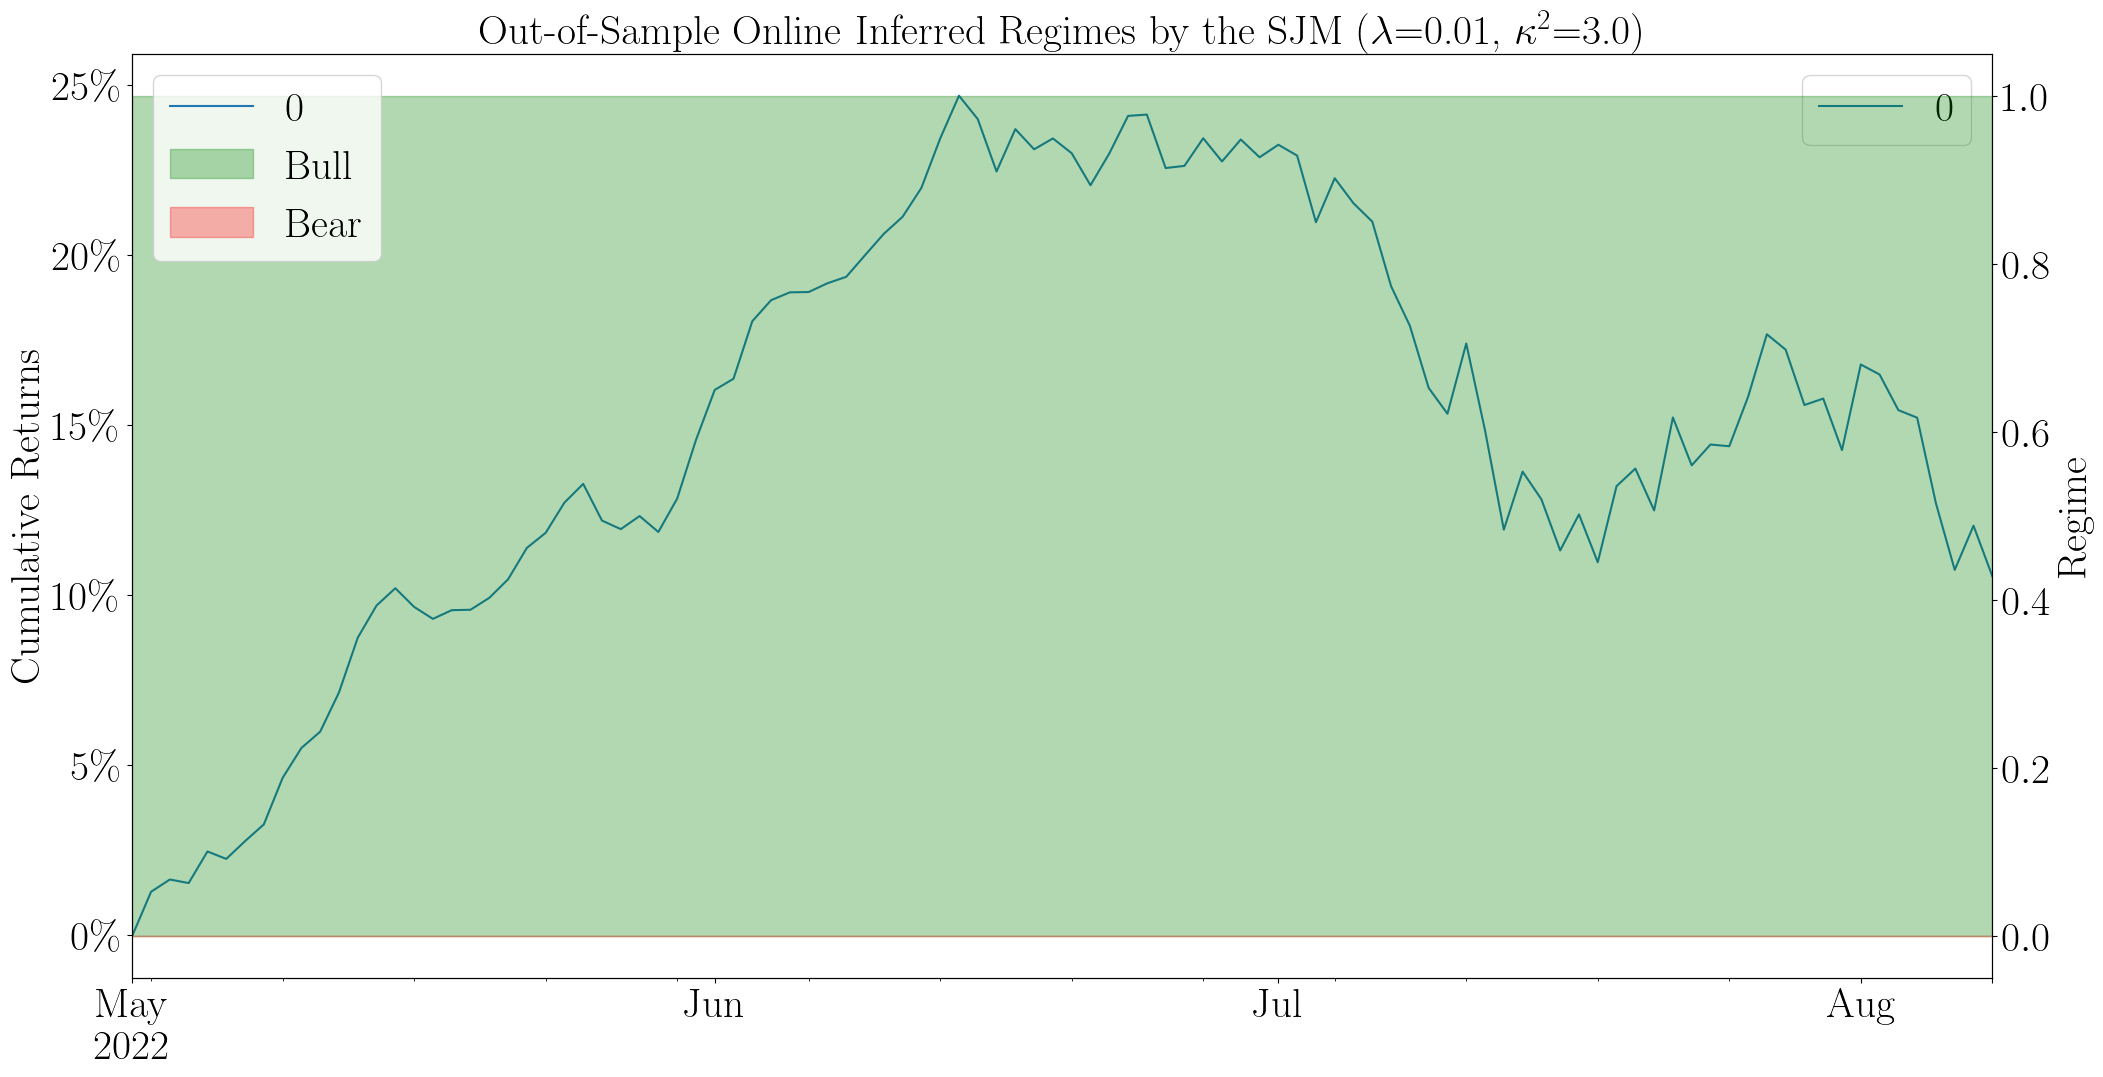

In [40]:
from jumpmodels.plot import plot_regimes_and_cumret, savefig_plt
from jumpmodels.utils import get_curr_dir
import matplotlib.pyplot as plt
import pandas as pd

# Create a date index for test data (e.g., starting May 1, 2022)
test_start = pd.Timestamp("2022-05-01")
test_dates = pd.date_range(start=test_start, periods=n_samples_test, freq='D')

# Convert the processed test data back into a DataFrame with the correct index
df_test_processed = pd.DataFrame(df_test_processed, index=test_dates, columns=df_test.columns)

# Re-create the test returns series with the same index
ret_ser_test = pd.Series(ret_ser_test.values if isinstance(ret_ser_test, pd.Series) else ret_ser_test, index=test_dates)

# Convert labels_test_online to a Series with the same index and fill any NaNs
labels_test_online = pd.Series(labels_test_online, index=test_dates).fillna(0).astype(int)

# Define the end date from the date range
test_end = test_dates[-1]

# Now call the plotting function
ax, ax2 = plot_regimes_and_cumret(labels_test_online, ret_ser_test, n_c=2, start_date=test_start, end_date=test_end)
ax.set(title=f"Out-of-Sample Online Inferred Regimes by the SJM ($\\lambda$={jump_penalty}, $\\kappa^2$={max_feats})")
savefig_plt(f"{get_curr_dir()}/plots/SJM_lambd-{jump_penalty}_max-feats-{max_feats}_test_online.pdf")
plt.show()
